題目: 從文章題目(title)檔中用SVD得到文字的潛在語意<br>
說明: TruncateSVD()是用來降低文字維度到2或3維的。我們如果以在這些文章題目(title)出現的單字當作字集(vocabulary)，<br>
再將這些字集以文章數長度編成獨熱碼(one hot encoding)，所以維度是文章數。<br>
SVD將其降至低維，再用matplotlib把前兩維攤在平面上，我們可用放大鏡來檢視各個字在這些文章題目中彼此的距離。<br>
<br>
延伸: 可用不同的tokenizer，不同的tokens_to_vector(count based vs frequency based vs TF-IDF)，<br>
不同的降維方式做改進潛在語意分布。<br>
<br>
範例程式檔名: lsa_潛在語意分析.py，以TruncateSVD 方式完成降維。<br>
模組: sklearn, matplotlib, numpy, nltk<br>
輸入檔: all_book_titles.txt，stopwords.txt<br>
成績: 改變原程式(也就是延伸)但仍能達到同樣或更佳效果<br>

In [1]:
import nltk
nltk.download(['punkt', 'wordnet'])

import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.manifold import TSNE

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
wordnet_lemmatizer = WordNetLemmatizer()

In [3]:
titles = [line.rstrip() for line in open('all_book_titles(作業數據).txt')]

和情緒分析用一樣的tokenizer

In [4]:
stopwords = set(w.rstrip() for w in open('stopwords(作業數據).txt'))

也可嘗試以nltk處理stopwords的方式

In [5]:
# from nltk.corpus import stopwords
# stopwords.words('english')

增加處理這問題必要的stopwords

In [6]:
stopwords = stopwords.union({
    'introduction', 'edition', 'series', 'application',
    'approach', 'card', 'access', 'package', 'plus', 'etext',
    'brief', 'vol', 'fundamental', 'guide', 'essential', 'printed',
    'third', 'second', 'fourth'
})

In [7]:
def my_tokenizer(s):
    s = s.lower()   # lowercase
    tokens = nltk.tokenize.word_tokenize(s)   # 將文字改為tokens
    tokens = [t for t in tokens if len(t) > 2]   # 去除短字
    tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens]   # 詞形還原
    tokens = [t for t in tokens if t not in stopwords]   # 去除stopwords
    tokens = [t for t in tokens if not any(c.isdigit() for c in t)]   # 移除數字，比方 "3rd edition"
    return tokens

先產生word-to-index map再產生word-frequency vectors<br>
同時儲存tokenized版本未來不需再做tokenization

In [8]:
word_index_map = {}
current_index = 0
all_tokens = []
all_titles = []
index_word_map = []
error_count = 0
for title in titles:
    try:
        title = title.encode('ascii', 'ignore').decode('utf-8')   # this will throw exception if bad characters
        all_titles.append(title)
        tokens = my_tokenizer(title)
        all_tokens.append(tokens)
        for token in tokens:
            if token not in word_index_map:
                word_index_map[token] = current_index
                current_index += 1
                index_word_map.append(token)
    except Exception as e:
        print(e)
        print(title)
        error_count += 1

In [9]:
print('Number of errors parsing file:', error_count, 'number of lines in file:', len(titles))
if error_count == len(titles):
    print('There is no data to do anything with! Quitting...')

Number of errors parsing file: 0 number of lines in file: 2373


產生輸入矩陣-是否出現(indicator)較比例(proportions)更準

In [10]:
def tokens_to_vector(tokens):
    x = np.zeros(len(word_index_map))
    for t in tokens:
        i = word_index_map[t]
        x[i] = 1
    return x

In [11]:
N = len(all_tokens)
D = len(word_index_map)
X = np.zeros((D, N))   # 字彙是列,文件是行
i = 0
for tokens in all_tokens:
    X[:,i] = tokens_to_vector(tokens)
    i += 1

In [12]:
tsne = TSNE(n_components=2)
Z = tsne.fit_transform(X)

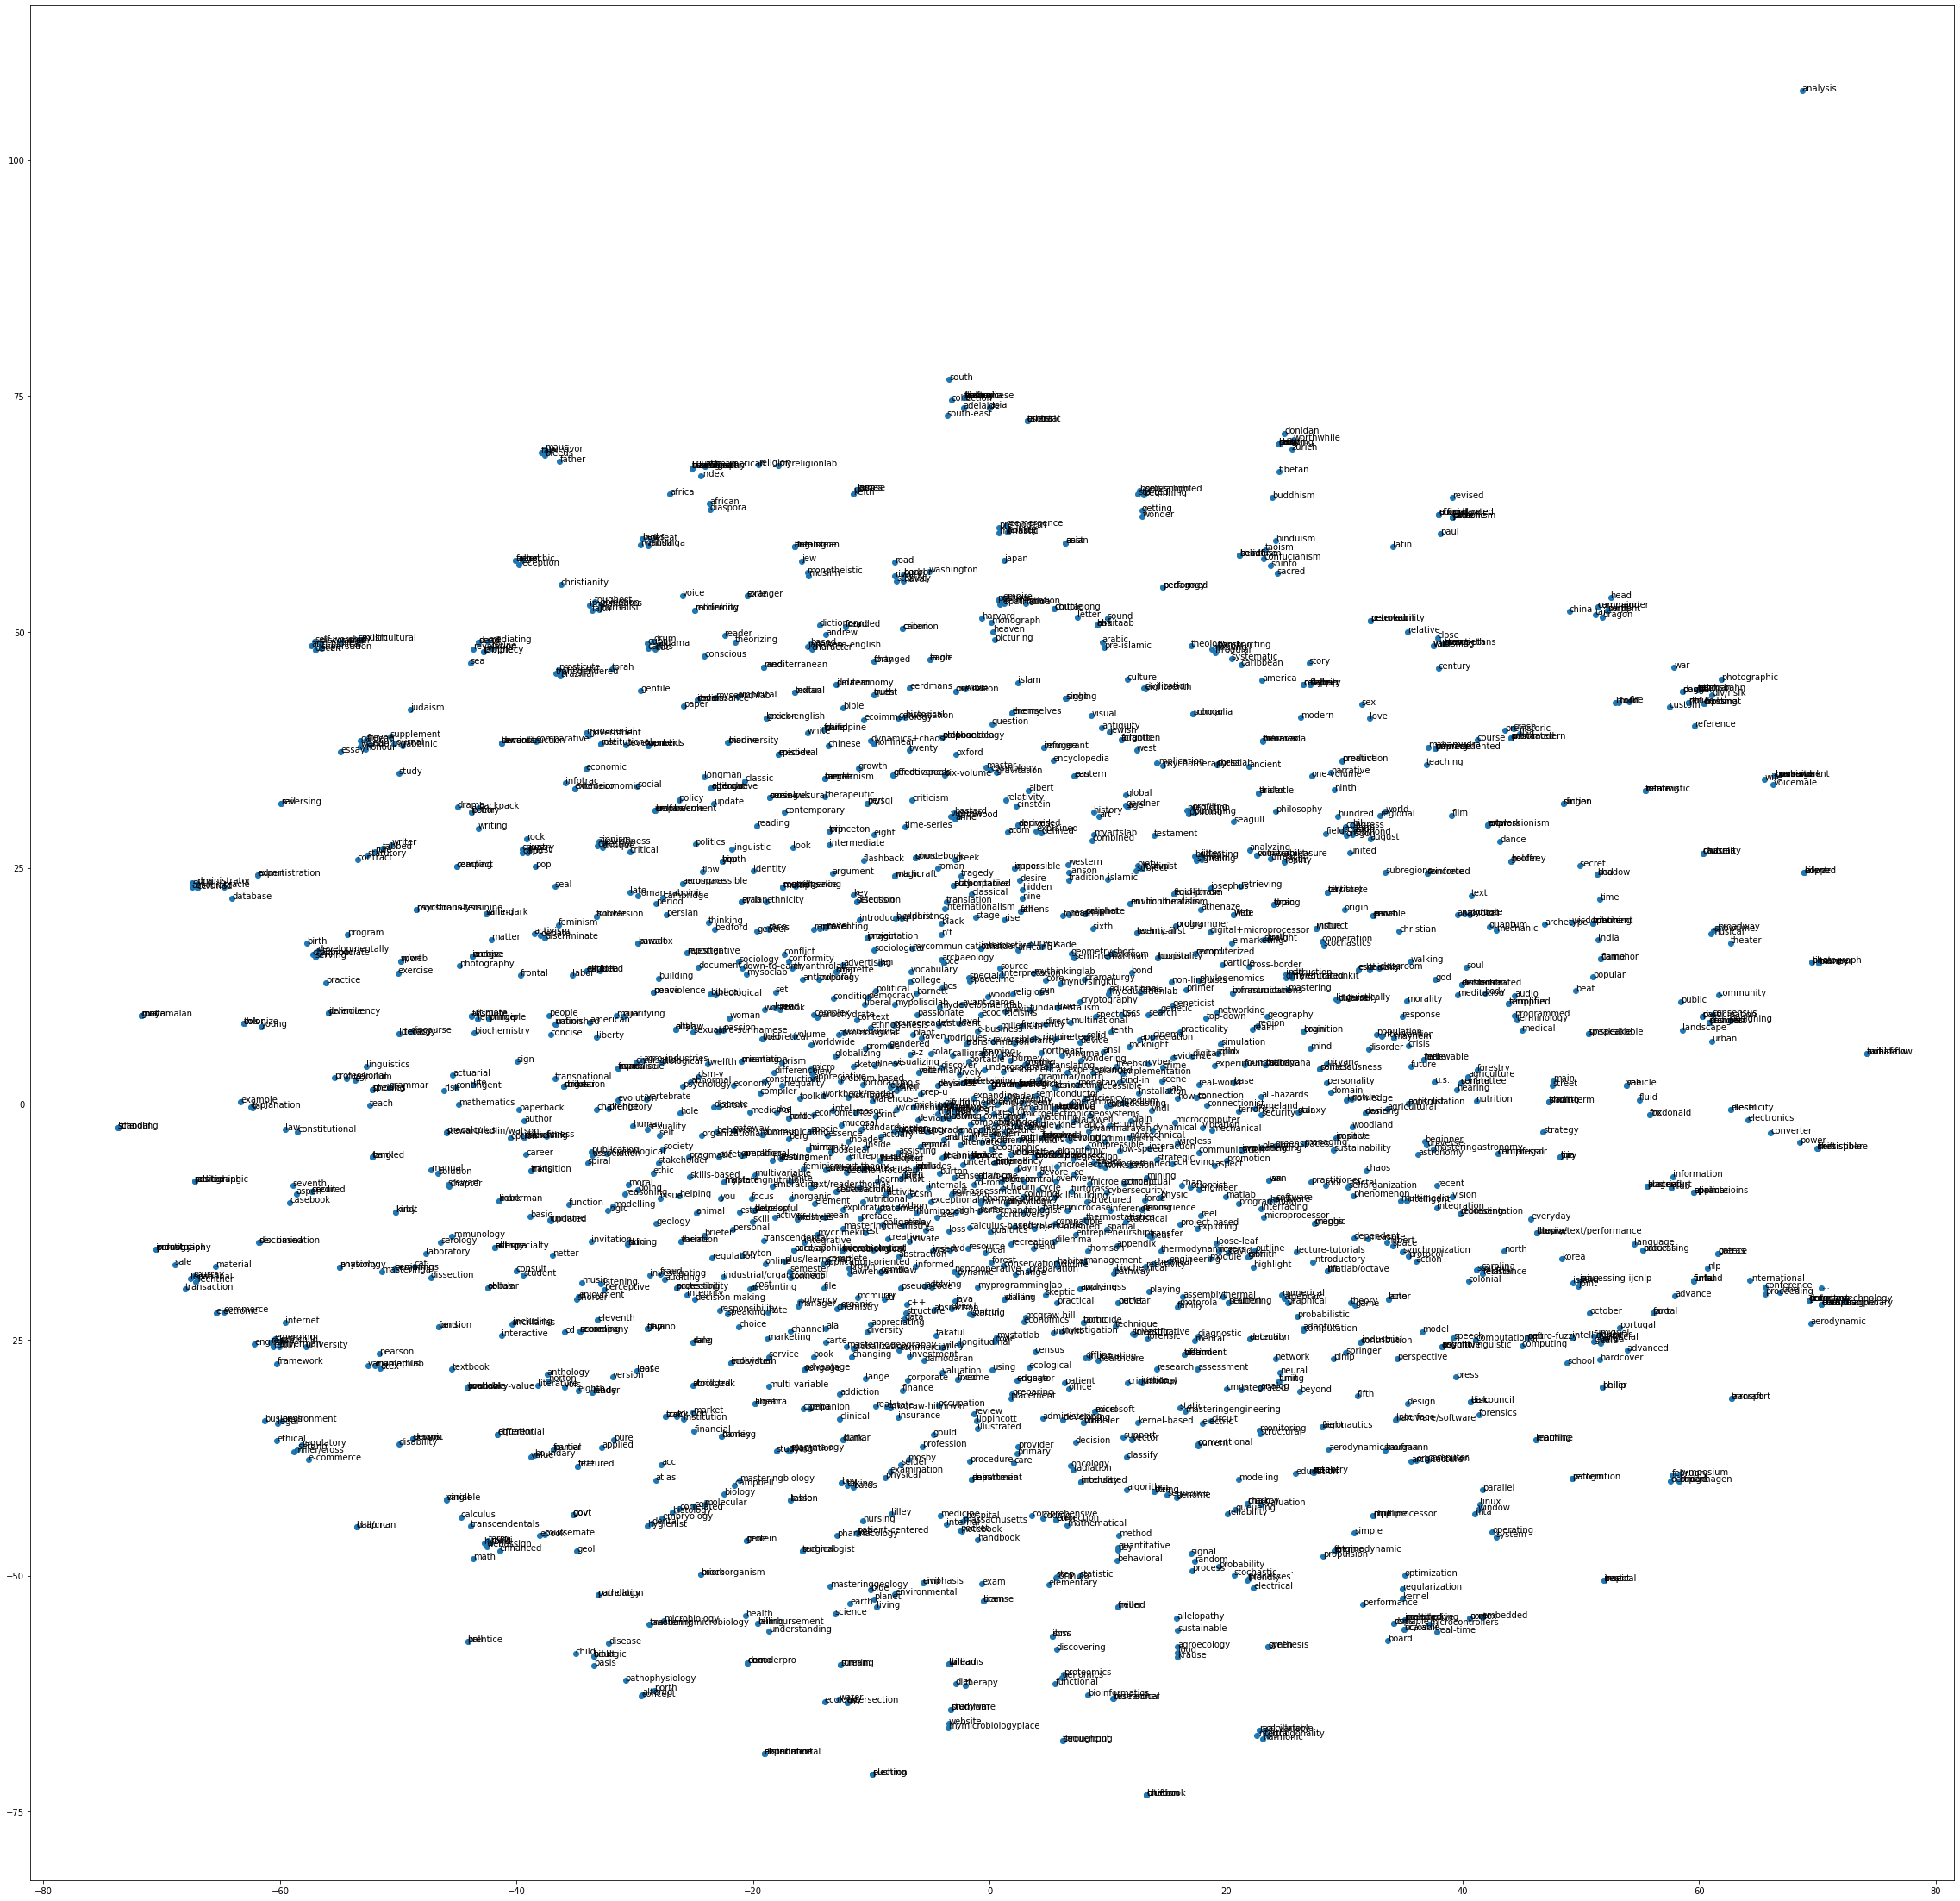

In [13]:
plt.figure(figsize=(40, 40))
plt.scatter(Z[:,0], Z[:,1])
for i in range(D):
    plt.annotate(s=index_word_map[i], xy=(Z[i,0], Z[i,1]))
plt.show()